In [1]:
from glob import glob
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # relevant only for my environment

In [2]:
# Constants
DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom',
   'Tambourine/Timbale', 
   'Cymbal',
   'Percussion',
   'Clap',
]

## if you want to use reddit dataset, uncomment this
MIDI_DRUM_MAP = {
    36: 0,
    35: 0,
    38: 1,
    40: 1,
    42: 2, # closed hihat
    44: 3, # pedal hihat
    46: 3, # open hihat
    41: 4, # low floor tom
    43: 4, # high floor tom
    45: 4, # low tom
    47: 4, # low-mid tom
    48: 4, # high-mid tom
    50: 4, # high tom
    54: 5, # tambourine 
    66: 5, # low timbale
    49: 6, # crash symbal 1
    51: 6, # ride  cymbal 1
    57: 6, # crash symbal 2
    59: 6, # ride cymbal 2
    67: 7, # high agogo
    58: 7, # low agogo
    69: 7, # cabasa
    70: 7, # maracas
    60: 7, # hi bongo
    61: 7, # low bongo
    62: 7, # mute hi congo
    63: 7, # open hi congo
    64: 7, # low conga
    37: 7, # side stick
    39: 8, # hand clap
}


DRUM_MIDI_MAP = [ # pianoroll to MIDI - reverse
    36, # 0 Kick / Bass Drum 1
    40, # 1 Snare / Electric Snare
    42, # 2 Hihat Closed
    46, # 3 Hihat Open
    47, # 4 Tom  / Low-mid Tom
    66, # 5 Low Timbale
    51, # 6 Cymbal
    63, # 7 Percussion / Open Hi Conga
    39  # 8 Clap
]
    
       
resolution  = 4 # separate quater into 4  = 16 notes per bar

nb_bars = 2 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note


In [3]:
import random
import numpy as np
import os
import pretty_midi
import random
from IPython.display import Audio

import matplotlib.pyplot as plt
%matplotlib inline

MIN_NB_ONSETS = 8

drum_dists = {}

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  

def play_drum_matrix(mat, offsets=None, tempo=120.0):
    # generate audio
    audio_data = get_audio_from_drum_matrix(mat, offsets=offsets, tempo=tempo)
    display(Audio(audio_data, rate=44100))
    return audio_data

def get_audio_from_drum_matrix(velocities, offsets=None, tempo=120.):
    pm = pretty_midi.PrettyMIDI(initial_tempo=tempo) # midi object
    pm_inst = pretty_midi.Instrument(0, is_drum=True) # midi instrument
    
    timestep = (60./tempo) / 4. # duration of a 16th note
    offset_unit = timestep / 2. # max offset == 32nd note
    
    for position, timeslot in enumerate(velocities):
        for inst, onset in enumerate(timeslot):
            if onset > 0.:
                note_number = DRUM_MIDI_MAP[inst]
                velocity = int(onset * 127.)
                
                offset = 0
                if offsets is not None:
                    offset = offsets[position, inst] * offset_unit

                start = timestep * position + offset
                end = timestep * (position + 0.5) + offset # duration doesn't matter much for rhythm track
                
                # create a midi note
                note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=start, end=end)
                pm_inst.notes.append(note)
    pm.instruments.append(pm_inst)

    # midi -> audio
    audio_data = pm.fluidsynth()
    return audio_data

In [6]:
import numpy as np

# make sure you have run "0_preprocess_midi.ipynb" in advance
matrices_drums = np.load("./data/matrices_drum_gm_clean.npz")['velocities']
matrices_onsets = np.load("./data/matrices_drum_gm_clean.npz")['onsets']
matrices_offsets = np.load("./data/matrices_drum_gm_clean.npz")['offsets']
matrices_genres = np.load("./data/matrices_drum_gm_clean.npz")['genre_ids']
GENRES = np.load("./data/matrices_drum_gm_clean.npz")['genres']

NB_GENRES = len(GENRES)
print(GENRES)
print(matrices_genres.shape)

['techno' 'house' 'jungle' 'downtempo' 'trance' 'garage' 'dnb' 'old_skool'
 'breakbeat']
(16647,)


techno 1427


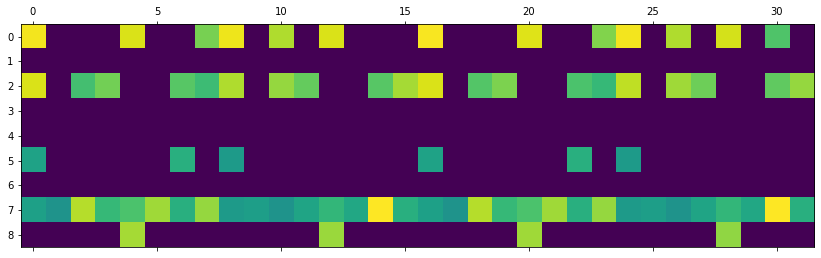

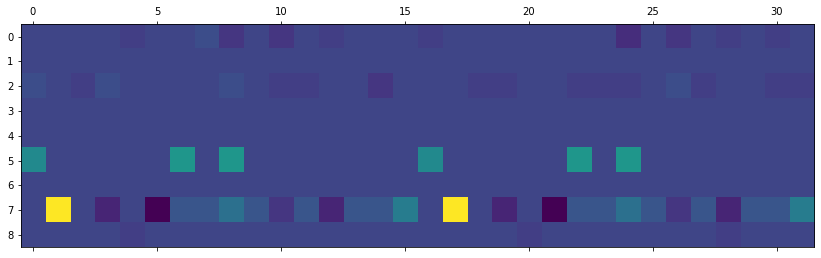

---------------------------
house 1296


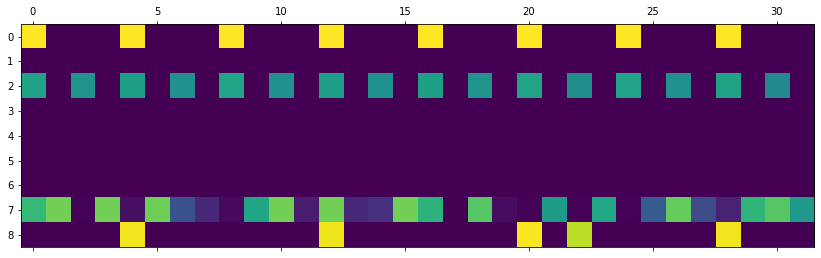

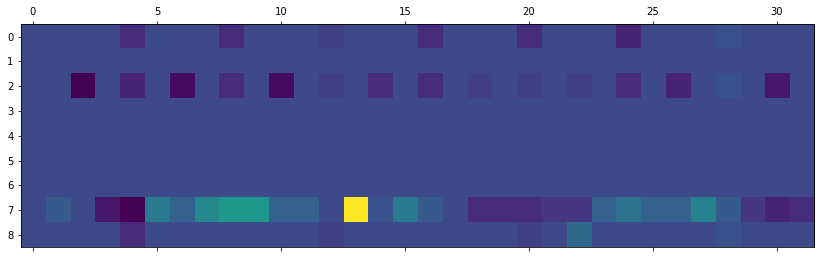

---------------------------
jungle 1730


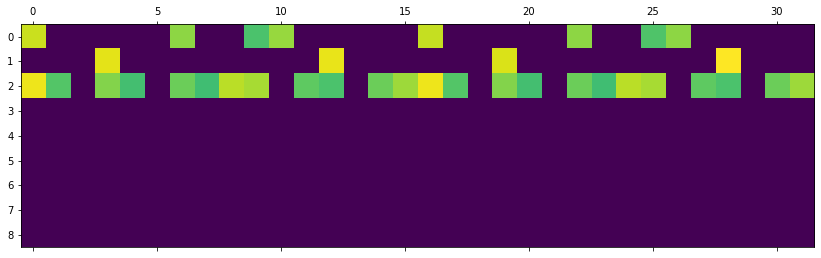

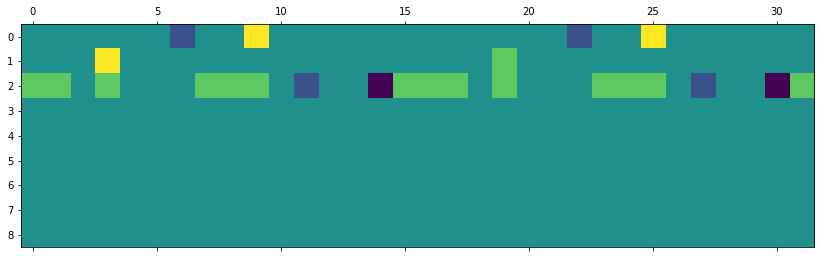

---------------------------
downtempo 1296


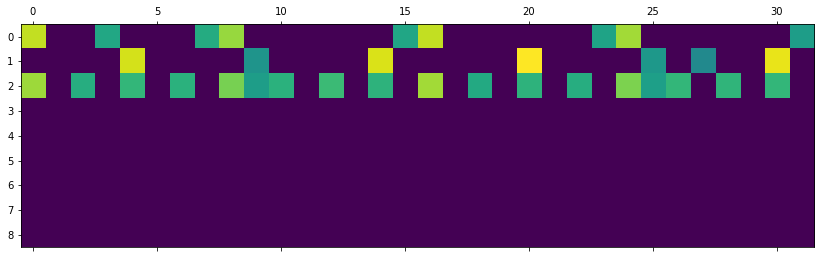

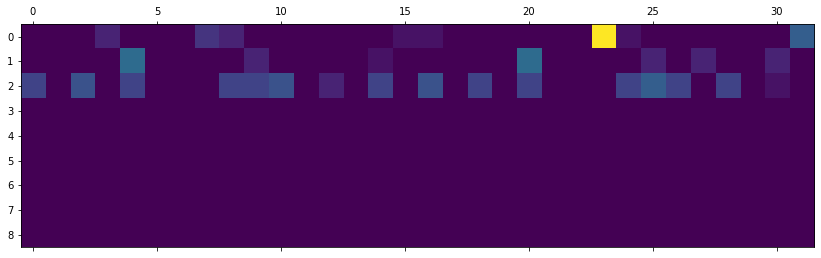

---------------------------
trance 1639


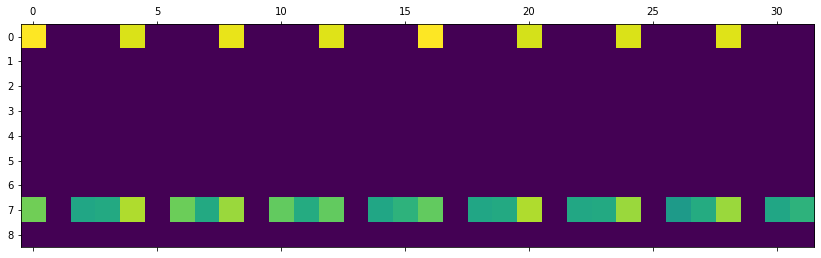

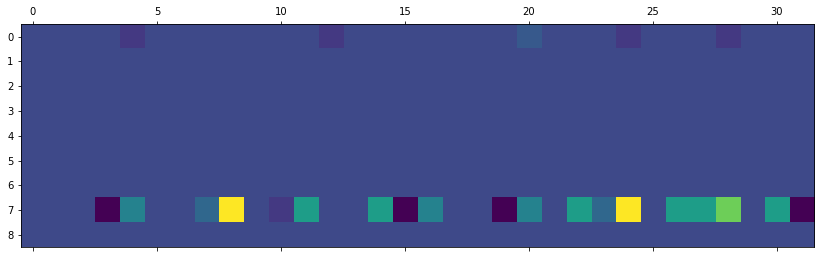

---------------------------
garage 2393


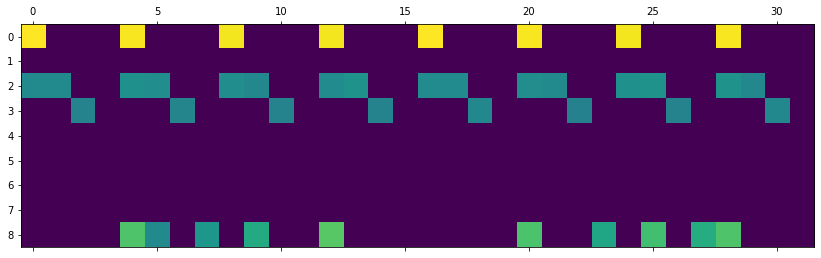

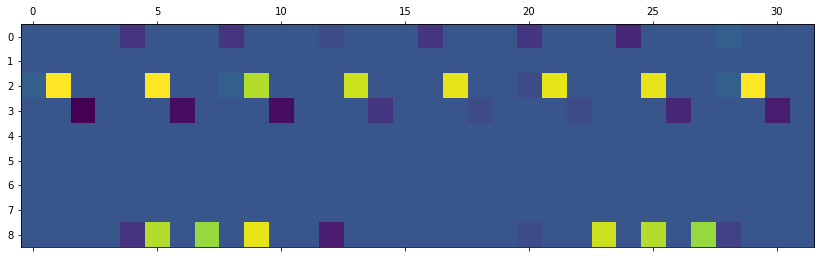

---------------------------
dnb 2502


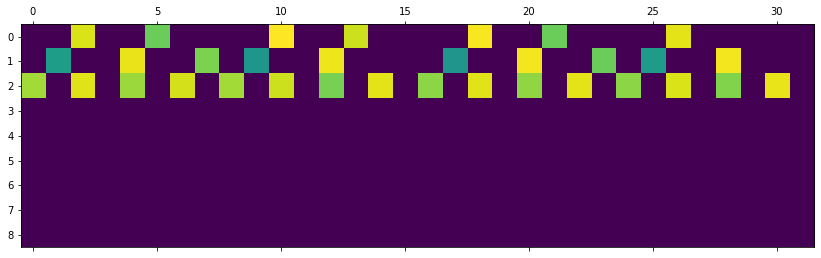

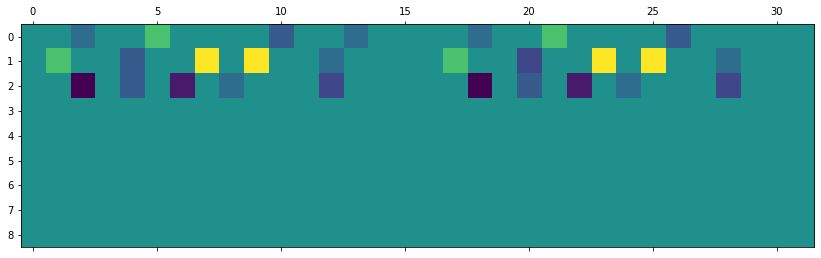

---------------------------
old_skool 1296


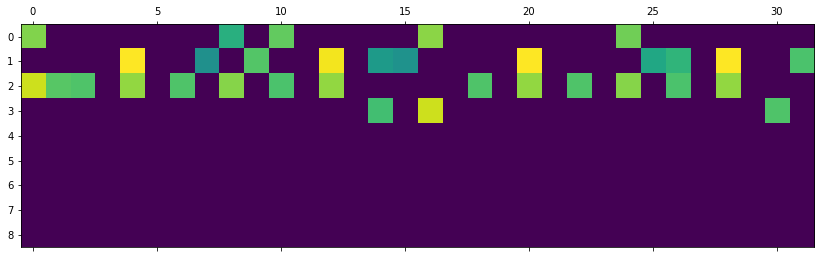

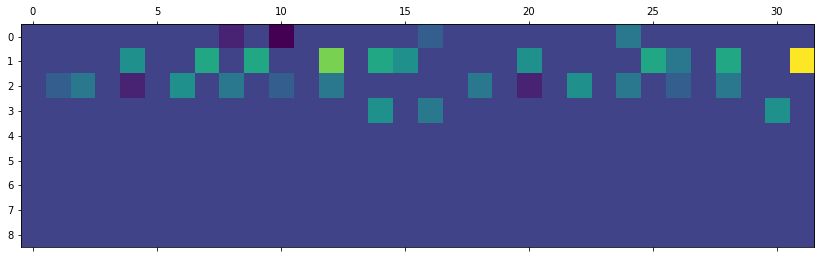

---------------------------
breakbeat 3068


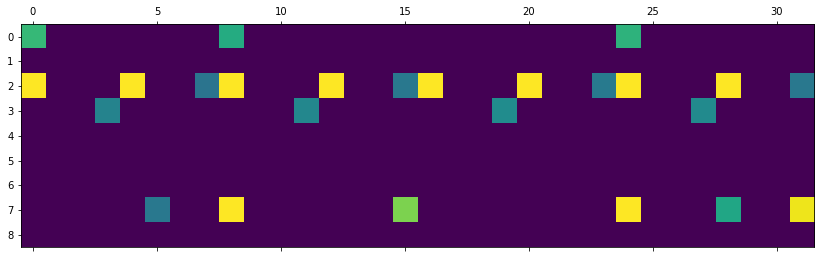

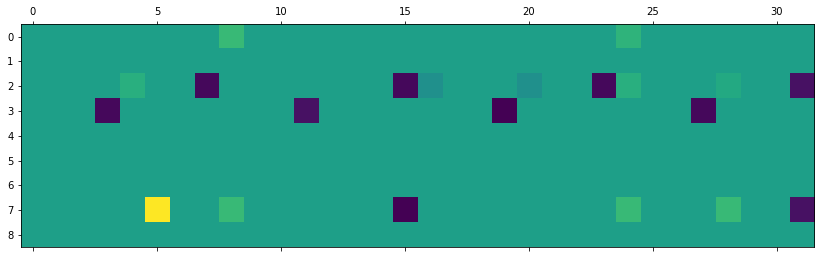

---------------------------


In [9]:
for i, genre in enumerate(GENRES):
    a = matrices_drums[matrices_genres == i]
    t = matrices_offsets[matrices_genres == i]
    print(genre, int(a.shape[0]))
    plot_drum_matrix(a[0])
    plot_drum_matrix(t[0])
    play_drum_matrix(a[0])
    print("---------------------------")

In [10]:
import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM
from keras.layers import Bidirectional, Lambda, Concatenate, Softmax, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras.models import Model
from keras import regularizers

droprate = 0.4

# input
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order
offset_input = Input(shape=(len_seq, nb_notes), name='offset_input')  # tensorflow order

x0 = Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(drum_input) 
x0 = BatchNormalization()(x0)
x0 = Bidirectional(LSTM(128, return_sequences=False, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(x0)
x0 = BatchNormalization()(x0)
#x0 = Dropout(droprate)(x0)

x1 = Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(offset_input) 
x1 = BatchNormalization()(x1)
x1 = Bidirectional(LSTM(128, return_sequences=False, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(x1)
x1 = BatchNormalization()(x1)
#x1 = Dropout(droprate)(x1)

x = Concatenate(axis=-1)([x0, x1])
x = Dropout(droprate)(x)
x = Dense(512, activation='sigmoid')(x)
output = Dense(NB_GENRES, activation='softmax', 
               kernel_regularizer=regularizers.l2(0.01), 
               activity_regularizer=regularizers.l1(0.01))(x)

model = Model([drum_input, offset_input], output)
model.summary()



Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
drum_input (InputLayer)         (None, 32, 9)        0                                            
__________________________________________________________________________________________________
offset_input (InputLayer)       (None, 32, 9)        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 32, 256)      141312      drum_input[0][0]                 
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 32, 256)      141312      offset_input[0][0]               
___________

In [11]:
from tensorboard_logger import configure, log_value

from datetime import datetime
now = datetime.now()
logdir_prefix = "/tmp/tf_logs_classification/"
logdir = logdir_prefix + now.strftime("%Y%m%d-%H%M%S") 
cmd = "tensorboard --logdir=" + logdir_prefix
print (cmd)

configure(logdir, flush_secs=5)

tensorboard --logdir=/tmp/tf_logs_classification/


In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import to_categorical 

genre_ids = to_categorical(matrices_genres, num_classes=NB_GENRES)

BATCH_SIZE = 64

tb = TensorBoard(log_dir=logdir, histogram_freq=1, batch_size=BATCH_SIZE, write_grads=True,update_freq='epoch')
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
cp = ModelCheckpoint("./tmp/classification_gm_{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=1, save_best_only=True, period=1)

optimizer = RMSprop ( lr = 0.0008 ) 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                      metrics=['accuracy'])

model.fit([matrices_onsets, matrices_offsets], genre_ids, 
        shuffle=True, batch_size=BATCH_SIZE, epochs=100, verbose=1, validation_split=0.2, callbacks=[tb, es, cp])


Train on 13317 samples, validate on 3330 samples



Epoch 1/100
13317/13317 [==============================] - 22s 2ms/step - loss: 2.4072 - accuracy: 0.4350 - val_loss: 2.9819 - val_accuracy: 0.1486


Epoch 00001: val_loss improved from inf to 2.98191, saving model to ./tmp/classification_gm_01-2.98.hdf5
Epoch 2/100
13317/13317 [==============================] - 19s 1ms/step - loss: 2.1010 - accuracy: 0.5320 - val_loss: 2.7861 - val_accuracy: 0.3189

Epoch 00002: val_loss improved from 2.98191 to 2.78615, saving model to ./tmp/classification_gm_02-2.79.hdf5
Epoch 3/100
13317/13317 [==============================] - 19s 1ms/step - loss: 1.9077 - accuracy: 0.5943 - val_loss: 2.4276 - val_accuracy: 0.4480

Epoch 00003: val_loss improved from 2.78615 to 2.42758, saving model to ./tmp/classification_gm_03-2.43.hdf5
Epoch 4/100
13317/13317 [==============================] - 19s 1ms/step - loss: 1.7555 - accuracy: 0.6380 - val_loss: 2.0510 - val_accuracy: 0.5718

Epoch 00004: val_loss impro

In [ ]:
model.save("./tmp/rhythm_classification_groove_with_offset.h5")